In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [2]:
path = 'D:/complete-proj/2021/07/apply/ilmuone-data/dataset'
all_files = glob.glob('dataset' + '/*.csv')

In [3]:
lst = []
for filename in all_files:
    # Read the data
    data = pd.read_csv(filename, index_col=None, header=0)
    
    # Fill the missing Sales data
    grpby_id = data.groupby(by='Identifier').mean().round(2)
    for identifier, sales_mean in zip(grpby_id.index, grpby_id.values):
        data['Sales'] = data['Sales'].mask((data['Sales'].isnull()) & (data['Identifier'] == identifier), sales_mean)
    
    # Convert Date to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Exclude certain Identifiers
    data = data[~data['Identifier'].str.contains(r'[0-9]')]
    
    # Groupby Date and set the freq index to 'D' (day)
    by_date = data.groupby(by='Date').sum()
    
    lst.append(by_date)

In [4]:
df = pd.concat(lst, axis=0)

In [5]:
df

,Sales
Date,
2010-02-15,92680.57
2010-02-16,91157.83
2010-02-17,92596.33
2010-02-18,90822.00
2010-02-19,90028.21
...,...
2021-04-23,142664.00
2021-04-26,141279.35
2021-04-27,140634.53


In [6]:
df = df.asfreq('D')

In [7]:
df['Sales'] = df['Sales'].interpolate()

In [8]:
df.index

DatetimeIndex(['2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18',
               '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22',
               '2010-02-23', '2010-02-24',
               ...
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29'],
              dtype='datetime64[ns]', name='Date', length=4092, freq='D')

In [16]:
df

,Sales
Date,
2010-02-15,92680.57
2010-02-16,91157.83
2010-02-17,92596.33
2010-02-18,90822.00
2010-02-19,90028.21
...,...
2021-04-25,141740.90
2021-04-26,141279.35
2021-04-27,140634.53


<AxesSubplot:xlabel='Date'>

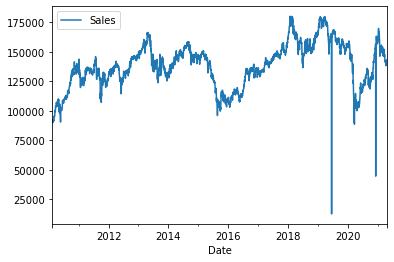

In [9]:
df.plot()

In [10]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

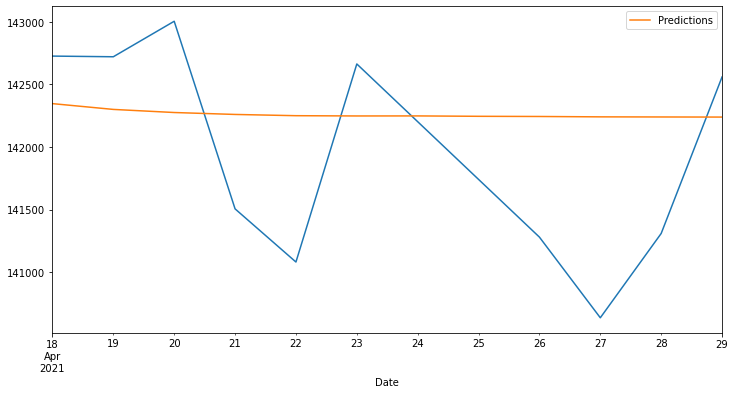

In [11]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, typ='levels').rename('Predictions')

ax = test['Sales'].plot(figsize=(12, 6))
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)

In [12]:
error1 = mean_squared_error(test['Sales'], predictions)
error2 = rmse(test['Sales'], predictions)
print(f'SARIMA(0,1,0)(2,0,0,12) MSE Error: {error1:11.10}')
print(f'SARIMA(0,1,0)(2,0,0,12) RMSE Error: {error2:11.10}')

SARIMA(0,1,0)(2,0,0,12) MSE Error: 642071.4722
SARIMA(0,1,0)(2,0,0,12) RMSE Error: 801.2936242


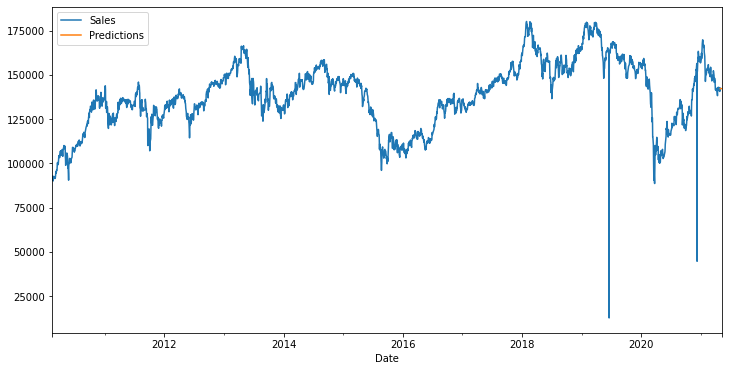

In [13]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(df), len(df)+11, typ='levels').rename('Predictions')

ax = df['Sales'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

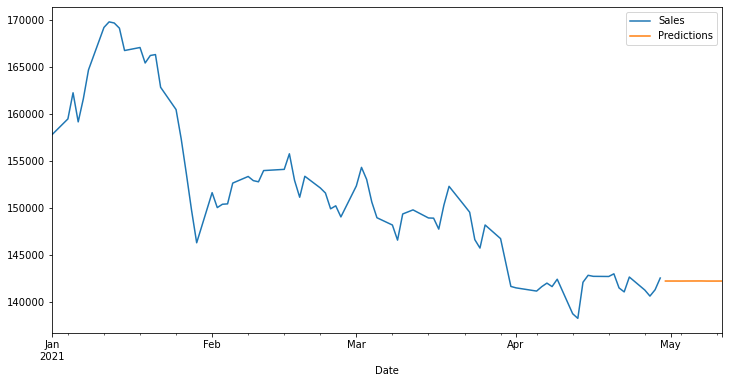

In [14]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(df), len(df)+11, typ='levels').rename('Predictions')

ax = df.loc['2021-01-01':'2021-04-29']['Sales'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [15]:
fcast

2021-04-30    142238.268551
2021-05-01    142237.481476
2021-05-02    142238.239872
2021-05-03    142236.291189
2021-05-04    142239.773206
2021-05-05    142241.259471
2021-05-06    142242.967837
2021-05-07    142244.568475
2021-05-08    142236.029084
2021-05-09    142234.872854
2021-05-10    142235.329765
2021-05-11    142236.754656
Freq: D, Name: Predictions, dtype: float64

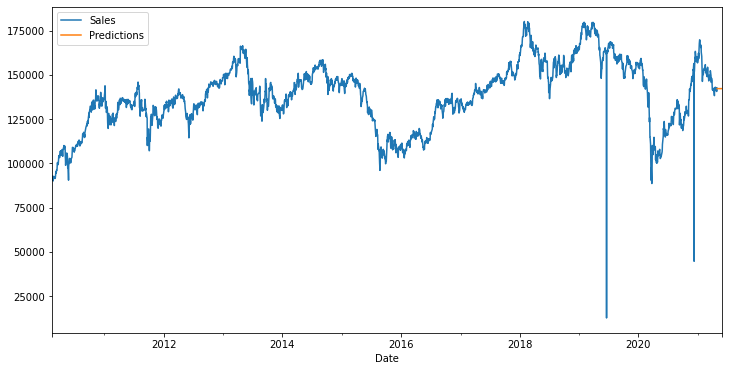

In [17]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(df), len(df)+30, typ='levels').rename('Predictions')

ax = df['Sales'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

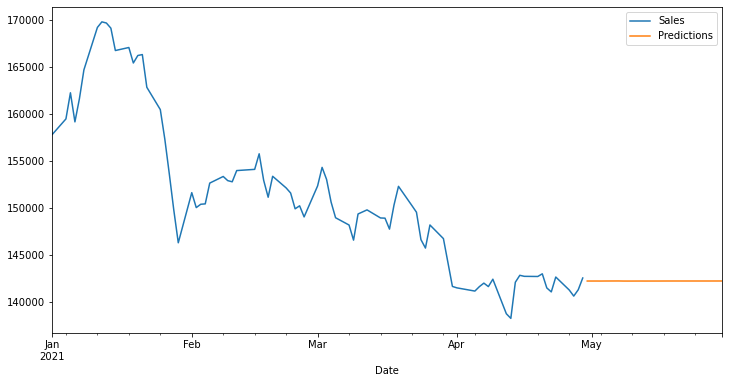

In [18]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(df), len(df)+30, typ='levels').rename('Predictions')

ax = df.loc['2021-01-01':'2021-04-29']['Sales'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

# ------------

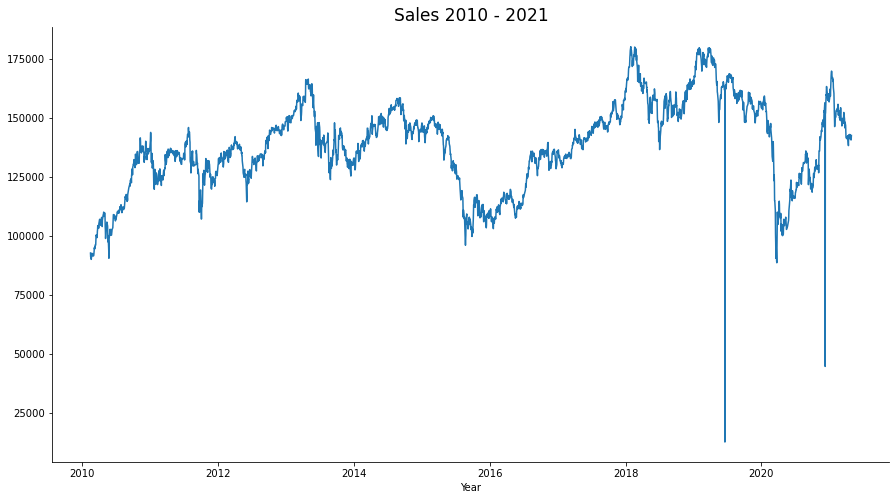

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.plot(df)

ax.set_title('Sales 2010 - 2021', size=17)
ax.set_xlabel('Year')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show();

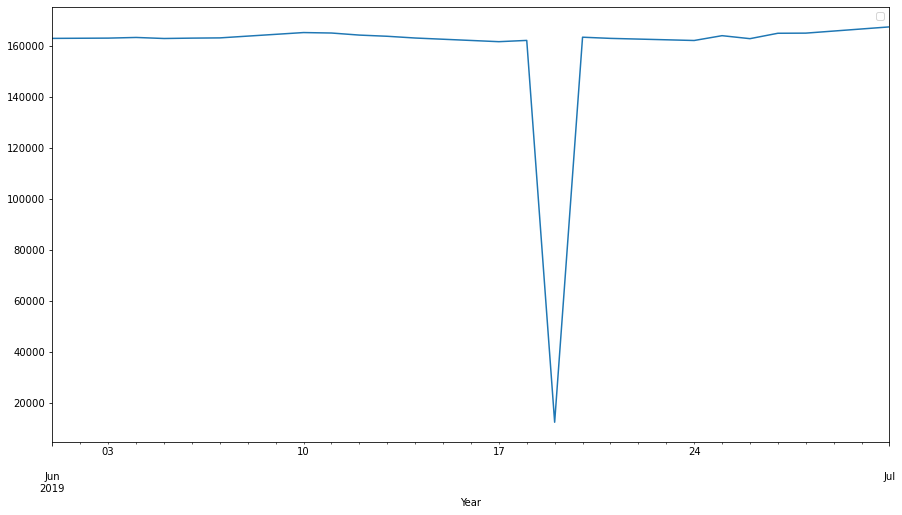

In [45]:
df.loc['2019-06-01':'2019-07-01'].plot(figsize=(15, 8))
plt.xlabel('Year')
plt.legend([])
plt.show();

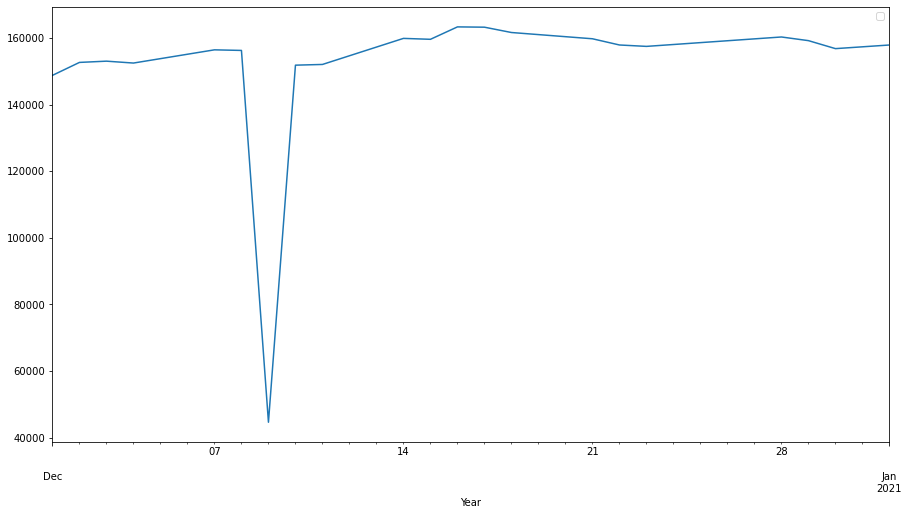

In [46]:
df.loc['2020-12-01':'2021-01-01'].plot(figsize=(15, 8))
plt.xlabel('Year')
plt.legend([])
plt.show();

In [47]:
df.loc['2019-06-19']

Sales    12617.0
Name: 2019-06-19 00:00:00, dtype: float64

In [48]:
df.loc['2020-12-09']

Sales    44665.81
Name: 2020-12-09 00:00:00, dtype: float64

# ----------

In [49]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(df), len(df) + 30, typ='levels').rename('Predictions')

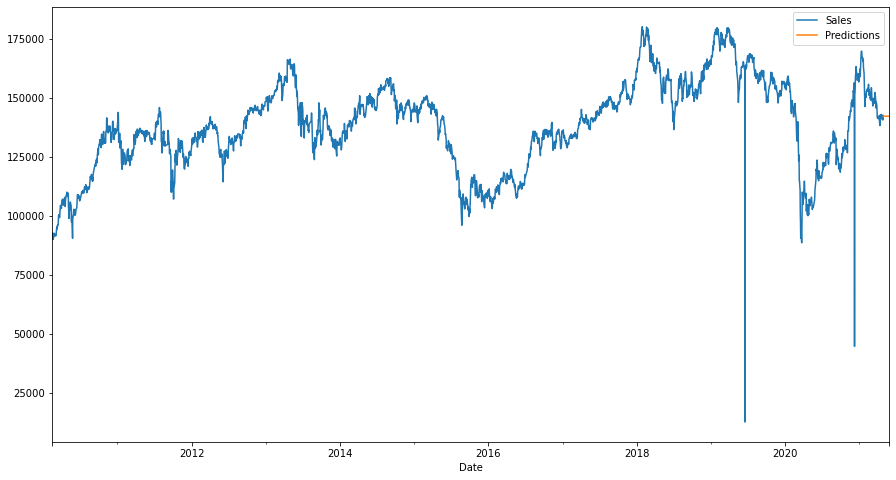

In [50]:
ax = df['Sales'].plot(legend=True, figsize=(15, 8))
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)

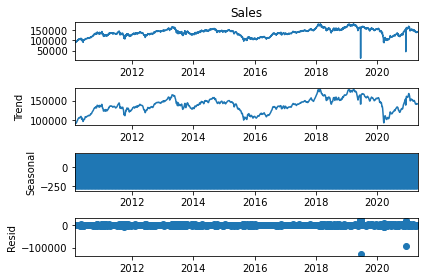

In [65]:
result = seasonal_decompose(df['Sales'], model='add')
result.plot();

In [56]:
result.trend.loc['2010-02-15':'2011-01-01']

Date
2010-02-15              NaN
2010-02-16              NaN
2010-02-17              NaN
2010-02-18     91289.267143
2010-02-19     91150.860000
                  ...      
2010-12-28    136132.833571
2010-12-29    136531.157857
2010-12-30    137042.801429
2010-12-31    137667.764286
2011-01-01    138767.764286
Freq: D, Name: trend, Length: 321, dtype: float64

<AxesSubplot:xlabel='Date'>

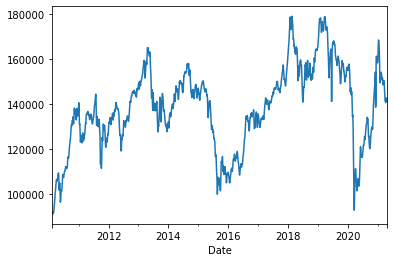

In [58]:
result.trend.plot()

<AxesSubplot:xlabel='Date'>

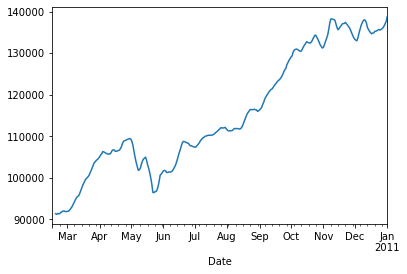

In [57]:
result.trend.loc['2010-02-15':'2011-01-01'].plot()

<AxesSubplot:xlabel='Date'>

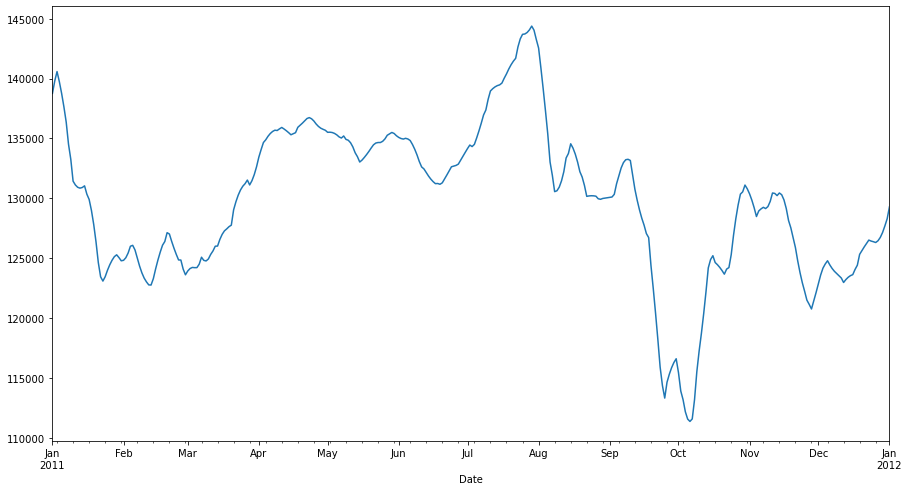

In [60]:
result.trend.loc['2011-01-01':'2012-01-01'].plot(figsize=(15, 8))

<AxesSubplot:xlabel='Date'>

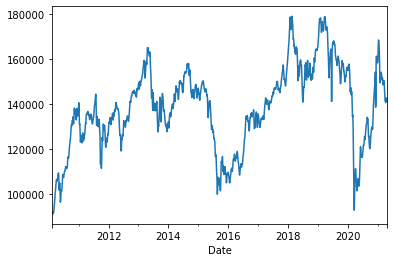

In [54]:
result.trend.plot()

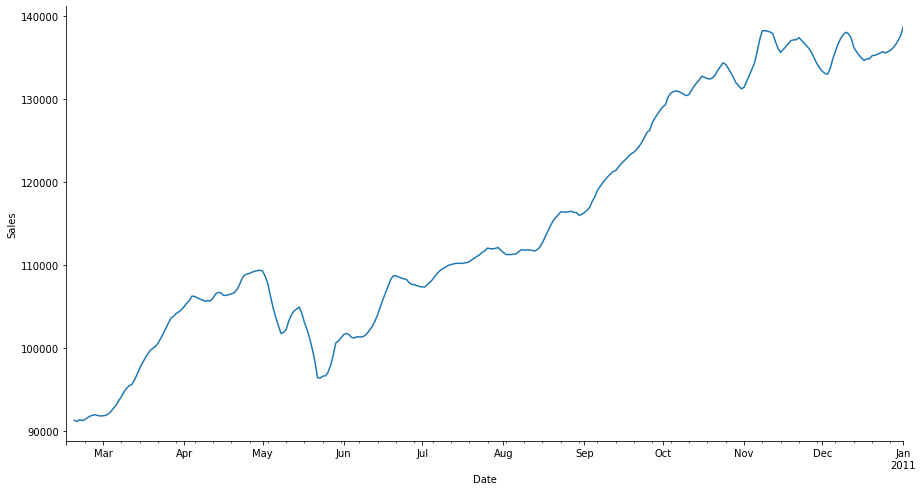

In [71]:
ax = result.trend.loc['2010-02-15':'2011-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

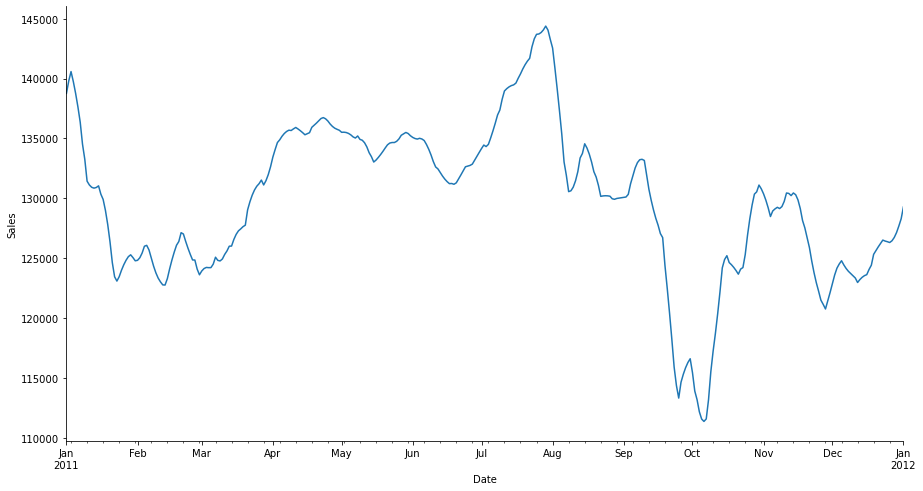

In [72]:
ax = result.trend.loc['2011-01-01':'2012-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

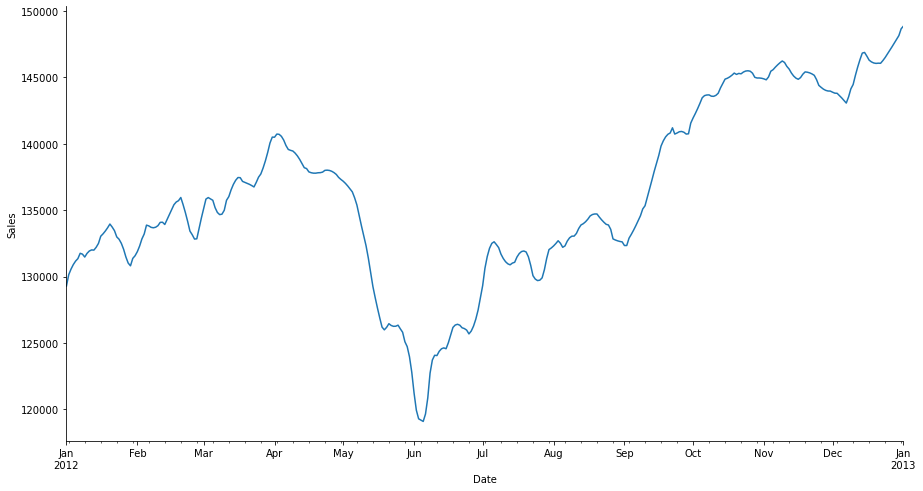

In [73]:
ax = result.trend.loc['2012-01-01':'2013-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

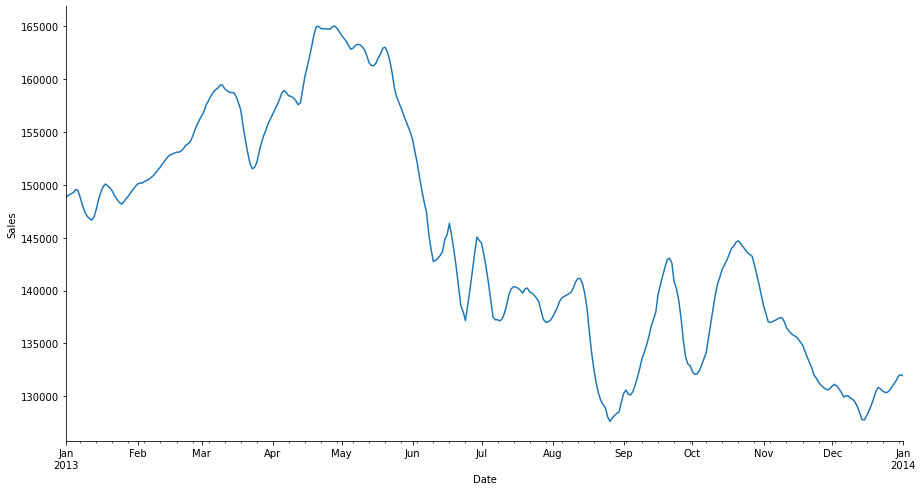

In [74]:
ax = result.trend.loc['2013-01-01':'2014-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

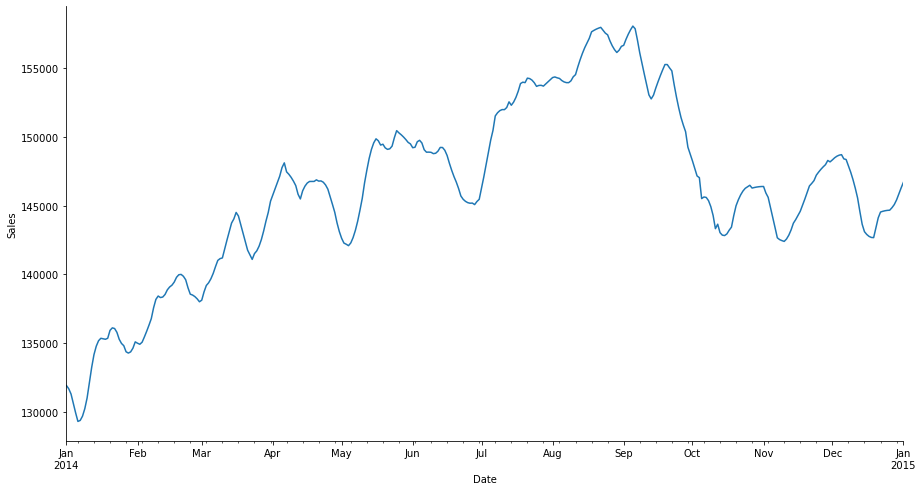

In [75]:
ax = result.trend.loc['2014-01-01':'2015-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

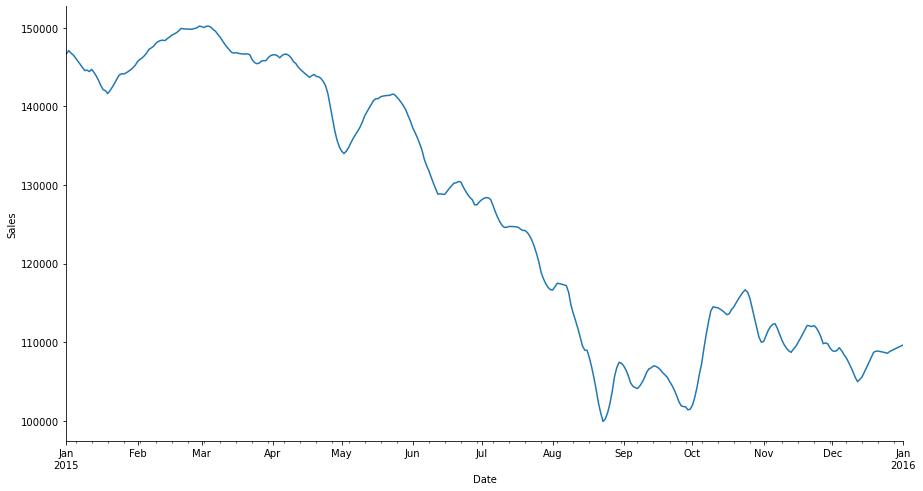

In [76]:
ax = result.trend.loc['2015-01-01':'2016-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

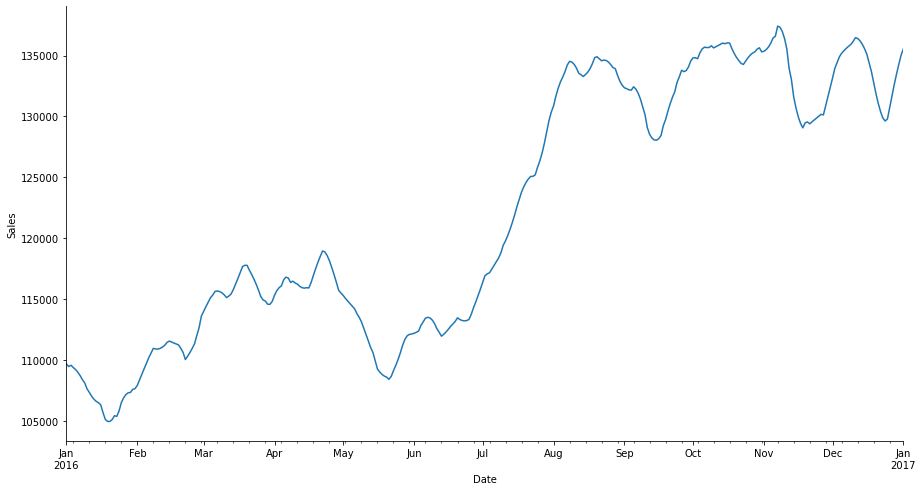

In [77]:
ax = result.trend.loc['2016-01-01':'2017-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

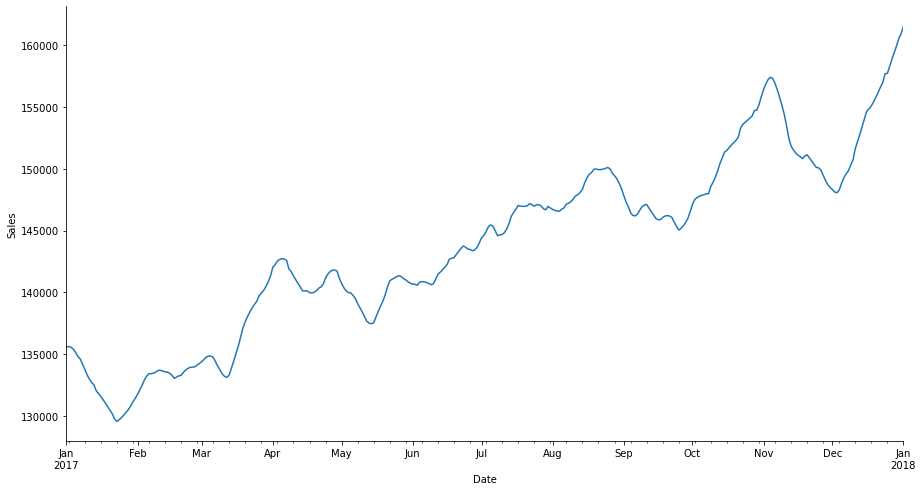

In [78]:
ax = result.trend.loc['2017-01-01':'2018-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

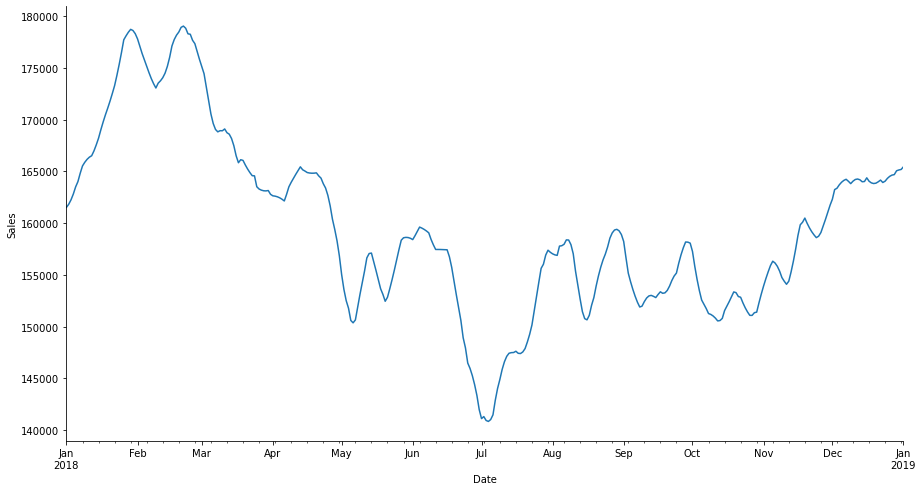

In [81]:
ax = result.trend.loc['2018-01-01':'2019-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

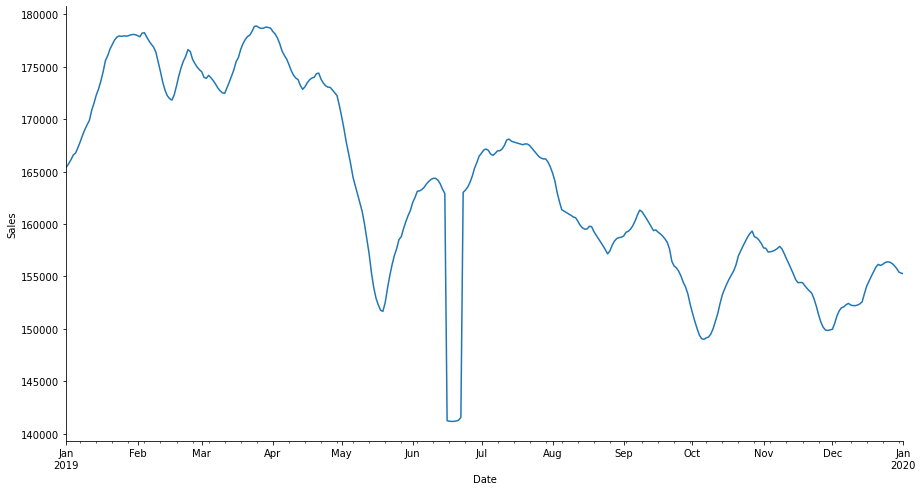

In [82]:
ax = result.trend.loc['2019-01-01':'2020-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

In [84]:
df.asfreq('M')

,Sales
Date,
2010-02-28,92002.825000
2010-03-31,103241.180000
2010-04-30,109527.140000
2010-05-31,102792.000000
2010-06-30,107077.810000
...,...
2020-11-30,146245.000000
2020-12-31,157320.188000
2021-01-31,149867.920000


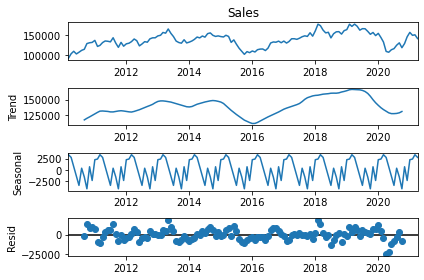

In [85]:
result2 = seasonal_decompose(df.asfreq('M')['Sales'], model='add')
result2.plot();

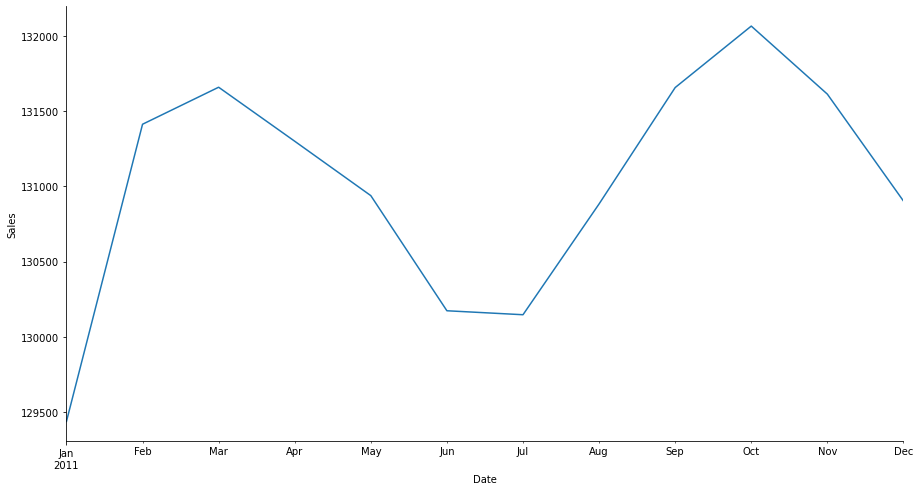

In [88]:
ax = result2.trend.loc['2011-01-01':'2012-01-01'].plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sales')
plt.show();

<AxesSubplot:xlabel='Date'>

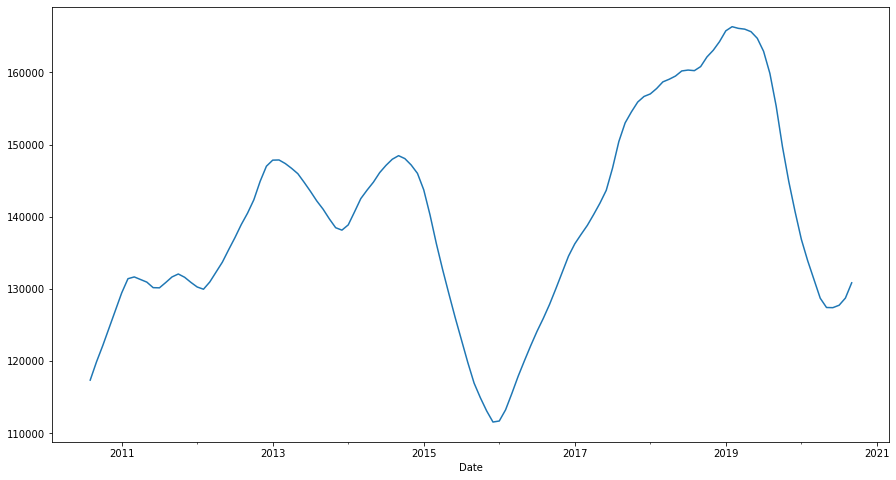

In [90]:
result2.trend.plot(figsize=(15, 8))

<AxesSubplot:xlabel='Date'>

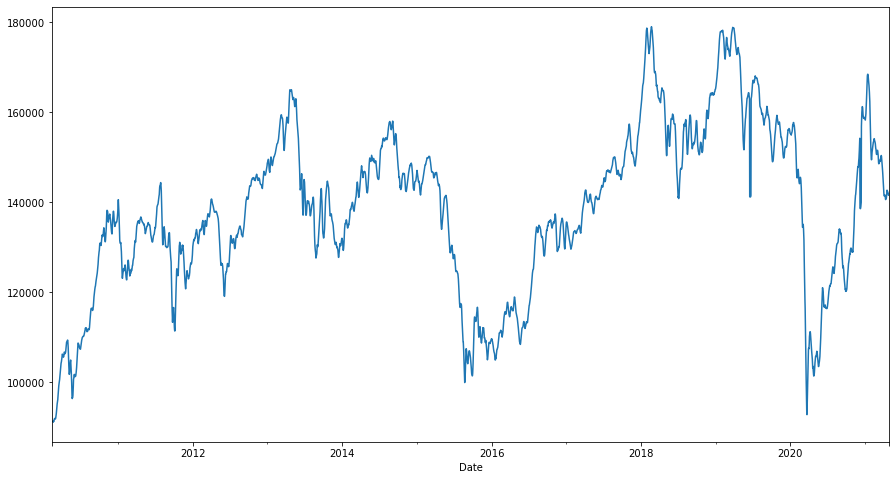

In [92]:
result.trend.plot(figsize=(15, 8))

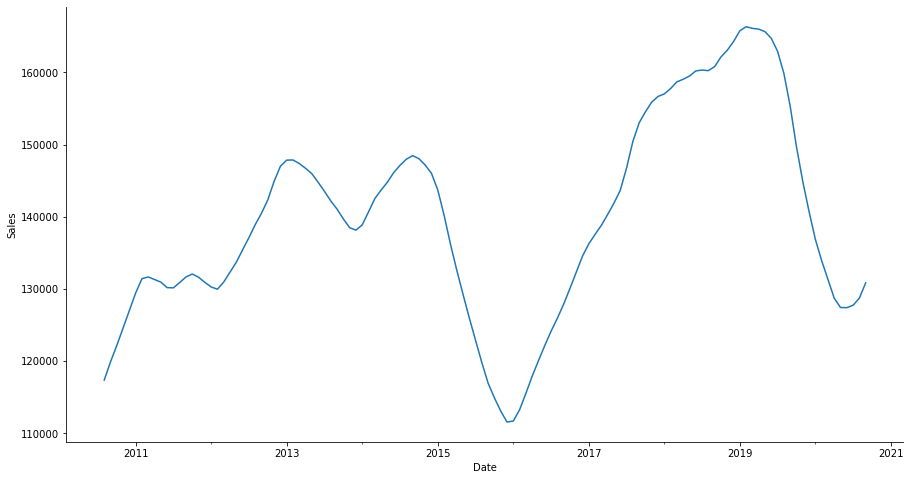

In [100]:
ax = result2.trend.plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('2010 - 2021 Trend', size=15)
ax.set_ylabel('Sales')
plt.show();

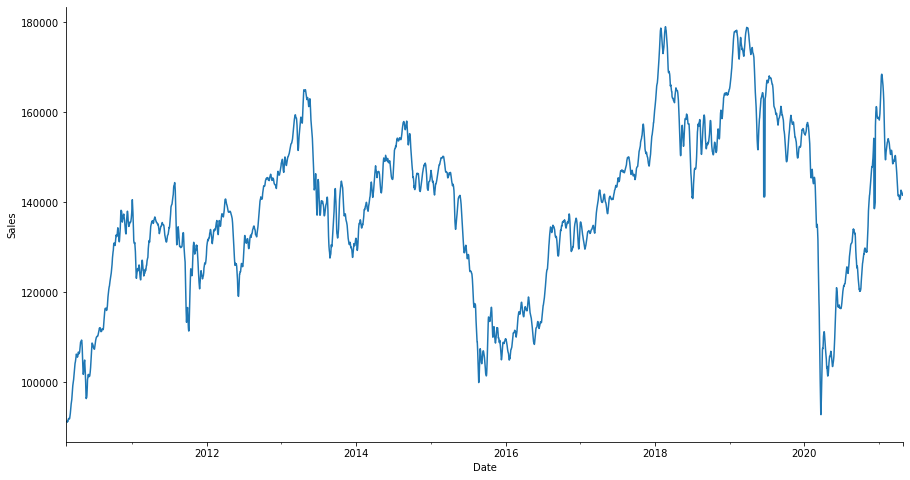

In [108]:
ax = result.trend.plot(figsize=(15, 8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('2010 - 2021 Trend', size=15)
ax.set_ylabel('Sales')
plt.show();

# ----------------

In [101]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(df), len(df) + 30, typ='levels').rename('Predictions')

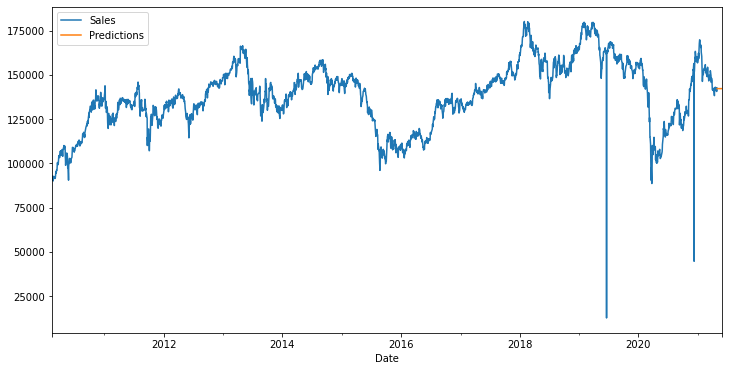

In [106]:
ax = df['Sales'].plot(legend=True, figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)

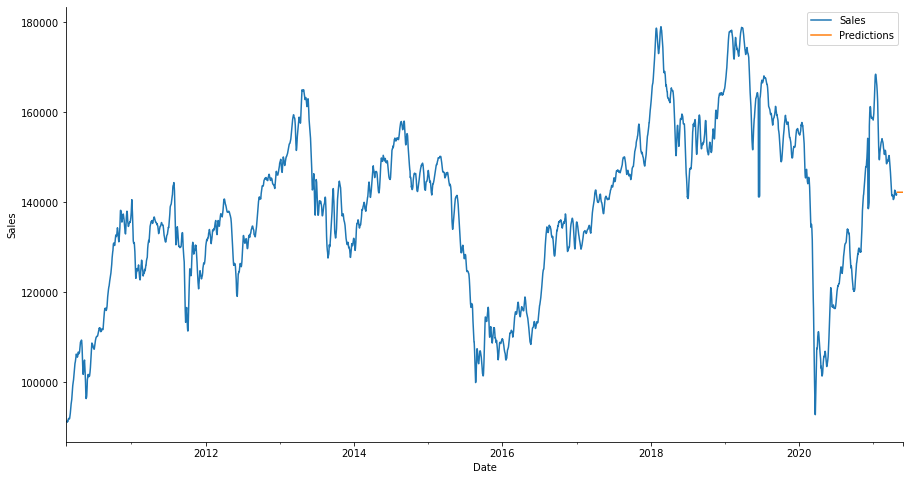

In [125]:
ax = result.trend.plot(figsize=(15, 8), legend=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Forecast Result', size=15)
ax.set_ylabel('Sales')
ax.legend(['Sales'])

fcast.plot(legend=True)
plt.show();

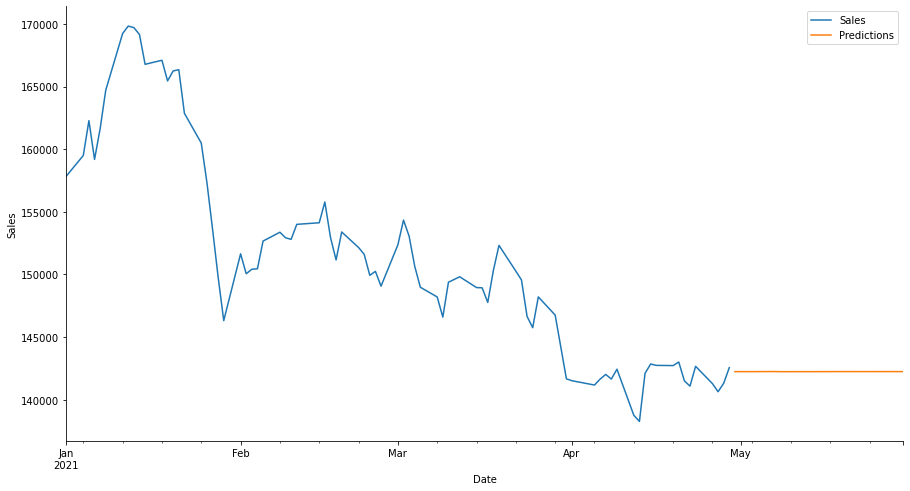

In [124]:
ax = df.loc['2021-01-01':'2021-04-29']['Sales'].plot(figsize=(15, 8), legend=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_title('Forecast Result', size=15)
ax.set_ylabel('Sales')
ax.legend(['Sales'])

fcast.plot(legend=True)
plt.show();

In [128]:
df.describe()

,Sales
count,4092.000000
mean,138481.347947
std,18395.013963
min,12617.000000
25%,128081.502500
50%,139337.720000
75%,150980.432500
max,180189.860000


In [130]:
fcast.mean()

142239.39886065503

In [131]:
df

,Sales
Date,
2010-02-15,92680.57
2010-02-16,91157.83
2010-02-17,92596.33
2010-02-18,90822.00
2010-02-19,90028.21
...,...
2021-04-25,141740.90
2021-04-26,141279.35
2021-04-27,140634.53
